# Dark Solitons In Bose Einstein Condensate

# Dark Solitons In Bose Einstein Condensate
May 2024

Joshua D. JOHN, Ph.D

This is my attempt to reproduce experiments on generating and observing dark solitons in Bose-Einstein Condensates. The reference papers are:

[1] Burger, S., Bongs, K., Dettmer, S.L., Ertmer, W., Sengstock, K., Sanpera, A., Shlyapnikov, G.V., & Lewenstein, M. (1999). Dark solitons in Bose-Einstein condensates. Quantum Electronics and Laser Science Conference. https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.83.5198

[2] Bongs, K., Burger, S., Hellweg, D., Kottke, M.L., Dettmer, S.L., Rinkleff, T., Cacciapuoti, L., Arlt, J.J., Sengstock, K., & Ertmer, W. (2003). Spectroscopy of dark soliton states in Bose?Einstein condensates. Journal of Optics B-quantum and Semiclassical Optics, 5.

[3] Denschlag, J., Simsarian, J. E., Feder, D. L., Clark, C. W., Collins, L. A., Cubizolles, J., Deng, L., Hagley, E. W., Helmerson, K., Reinhardt, W. P., Rolston, S. L., Schneider, B. I., & Phillips, W. D. (2000). Generating solitons by phase engineering of a bose-einstein condensate. Science (New York, N.Y.), 287(5450), 97–101. https://doi.org/10.1126/science.287.5450.97

#### Prerequisites
1. An account on Oqtant. You can register here:
    https://oqtant.infleqtion.com/
    
2. Oqtant installed on your system:
    https://oqtant-docs.infleqtion.com/INSTALL/
    
3. Available Oqtant Jobs.
    This notebook will use up to 16 jobs.

I run the simulation followed by two ways to run the experiments on the Oqtant system, either as a list of jobs, or as a batch. I recomment batching since this guarantees contiguous access to the system for all the jobs in the batch, without interruption form other users in the queue.


### Imports and Login

In [1]:
from oqtant.schemas.quantum_matter import QuantumMatterFactory
from oqtant.schemas.quantum_matter import QuantumMatter as qm
from oqtant.schemas.output import Gaussian_dist_2D
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import scipy.optimize as opt
from IPython.display import HTML

qmf = QuantumMatterFactory()
qmf.get_login()

Auth(children=(HBox(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x12\x00\x00\x00\xc…

In [2]:
qmf.get_client()

Job Limits:
╒═══════════════╤═══════════════════╤════════════════════╤════════════════════╕
│   Daily Limit │   Daily Remaining │   Standard Credits │   Priority Credits │
╞═══════════════╪═══════════════════╪════════════════════╪════════════════════╡
│           100 │               100 │                100 │                 38 │
╘═══════════════╧═══════════════════╧════════════════════╧════════════════════╛


### Phase Imprinting
#### Step phase

Text(0, 0.5, 'Landscape height (kHz)')

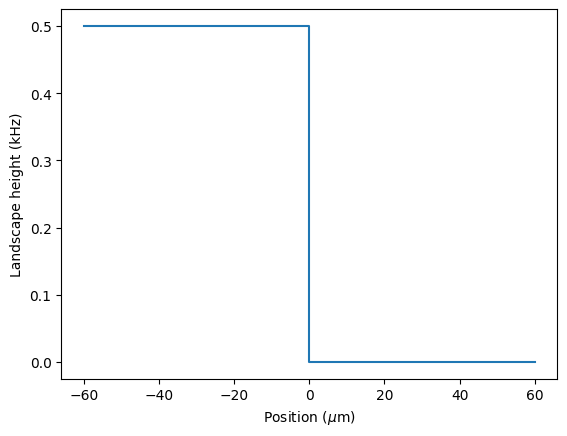

In [3]:
positions = [-60, 0, 0, 60]
heights_ramp = [0.5, 0.5, 0, 0]

plt.figure()
plt.plot(positions, heights_ramp)
plt.xlabel("Position ($\mu$m)")
plt.ylabel("Landscape height (kHz)")

#### Flash

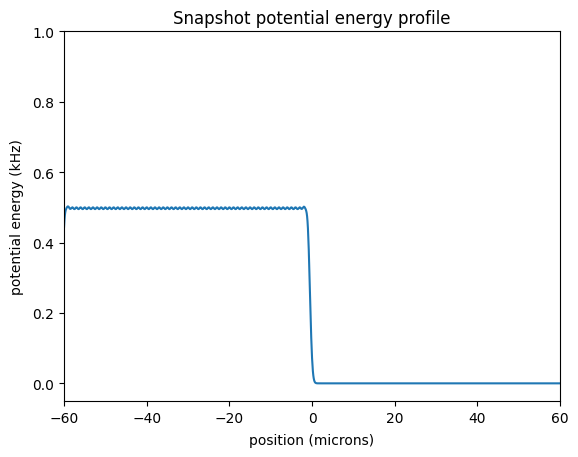

In [4]:
time_evolve = 1  # end time for periodic snapshot

snapshot_zero = qmf.create_snapshot(
    time=0, positions=positions, potentials=heights_ramp, interpolation="LINEAR"
)

snapshot_one = qmf.create_snapshot(
    time=time_evolve,
    positions=[0, 0],
    potentials=[0, 0],
    interpolation="LINEAR",
)

snapshot_zero.show_potential(xlimits=[-60, 60], ylimits=[-0.05, 1])

### Jobs

In [5]:
landscape_slant = qmf.create_landscape(snapshots=[snapshot_zero, snapshot_one])
sim_matter_imprint = qmf.create_quantum_matter(
    landscape=landscape_slant,
    image="IN_TRAP",
    lifetime=5,
    name="dipole mode imprinting",
)

sim_matter_collective = qmf.create_quantum_matter(
    landscape=landscape_slant,
    image="IN_TRAP",
    lifetime=80,
    name="dipole mode collective motion",
)

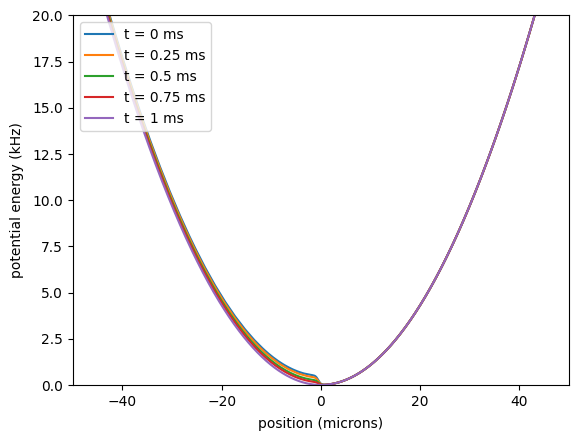

In [6]:
sim_matter_imprint.show_potential(
    [0, 0.25, 0.5, 0.75, 1], xlimits=[-50, 50], ylimits=[0, 20]
)

### Run Imprint Job

In [7]:
sim_matter_imprint.submit(sim=True)
sim_matter_imprint.get_result()

submitted simulation
ground state calculation in progress       
ground state calculation complete          
trapped simulation in progress             
trapped simulation complete                   
Simulation complete.


### Animations
#### Phase

In [8]:
phase_animation = sim_matter_imprint.sim.animate_phase(
    frame_interval=1, show_potential=True
)
HTML(phase_animation.to_jshtml())

#### Density

In [9]:
density_animation = sim_matter_imprint.sim.animate_density(
    frame_interval=1, show_potential=True
)
HTML(density_animation.to_jshtml())

KeyboardInterrupt: 

#### Density Profile

In [ ]:
profiles = sim_matter_imprint.sim.animate_profiles(frame_interval=1)
HTML(profiles.to_jshtml())

#### Current

In [ ]:
current_animation = sim_matter_imprint.sim.animate_current(frame_interval=1)
HTML(current_animation.to_jshtml())

### Analyze Speed

In [ ]:
# Line function used for fitting
def posline(x, a, b):
    return a * x + b

def negline(x, a, b):
    return -a * x + b

In [ ]:
# Get the position and time grid for the simulation data.
# Don't forget to convert from simulation units to experimental units!
times = np.array(sim_matter_imprint.sim.times) * sim_matter_imprint.sim.qm_potential.sim_time_to_oqt
xs = (
    np.array(sim_matter_imprint.sim.wavefunction.three_d_grid.x[0])
    * sim_matter_imprint.sim.qm_potential.sim_length_to_oqt
)
idx1 = 1  # first time index where the density wave appears
times_fit = times[
    idx1:
]  # List of times corresponding to the list of peak positions below

times_fitt = times[
    idx1:
]  # List of times corresponding to the list of peak positions below
# Get initial cloud density before density wave begins for baseline subtraction
_, _, _, density_baseline = sim_matter_imprint.sim.get_column_densities(time_ms=0)

# Initialize arrays
densities = np.zeros(
    (len(xs), len(times))
)  # Store the density distribution column sum over time
posns = []  # position of peak densities at each timestep
posnst = [] # position of trough densities at each time step

# Extract simulated density wave data from each timestep
for i, time in enumerate(times):
    _, _, _, density = sim_matter_imprint.sim.get_column_densities(time_ms=time)
    densities[:, i] = density - density_baseline
    posns.append(xs[np.argmax(densities[:, i])])  # Store the position of the peak density
    posnst.append(xs[np.argmin(densities[:, i])])  # Store the position of the trough density

# Ignore the first 'idx1' points when fitting to a line
posns_fit = posns[idx1:]
posns_fitt = posnst[idx1:]

# Fit peak density positions to a line
initial_guess = np.array([2, posns_fit[0]])
bl = initial_guess - [1.5, 10]
bu = initial_guess + [1.5, 10]

popt_sim, _ = opt.curve_fit(
    posline, times_fit, posns_fit, p0=initial_guess, bounds=(bl, bu)
)

# Fit trough density positions to a line
initial_guesst = np.array([2, posns_fitt[0]])
blt = initial_guesst - [1.5, 10]
but = initial_guesst + [1.5, 10]

popt_simt, _ = opt.curve_fit(
    negline, times_fitt, posns_fitt, p0=initial_guesst, bounds=(blt, but)
)


In [ ]:
# Plot the peak density positions versus time in the simulator
plt.figure(figsize=(8, 5))
plt.title(f"Simulator speed of sound: {popt_sim[0]:0.2f} mm/s, speed of soliton: {popt_simt[0]:0.2f} mm/s")
plt.plot(times_fit, posns_fit, "o", label="Simulator data")
plt.plot(times_fit, posline(times_fit, *popt_sim), "--", label="Fitted line")
plt.plot(times_fitt, posns_fitt, "*", label="Soliton Simulator data")
plt.plot(times_fitt, negline(times_fitt, *popt_simt), "--", label="Fitted line")
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Position (um)")
plt.show()

#### 2D plot of the simulator density wave

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
im = ax.imshow(
    np.flip(densities, axis=0), aspect=0.1, extent=(times[0], times[-1], xs[0], xs[-1])
)
ax.plot(
    times,
    posline(times, *popt_sim),
    "r-",
    label=f"Speed of sound: {popt_sim[0]:0.2f} mm/s",
)
ax.plot(
    times,
    negline(times, *popt_simt),
    "r-",
    label=f"Speed of soliton: {popt_simt[0]:0.2f} mm/s",
)
ax.set_xlabel(r"Position [μmμm\mu m]")
ax.set_ylabel("Time [ms]")
plt.legend()
plt.colorbar(im, ax=ax, label="Relative density (Atoms/mumu\\mum22^2)")
ax.set_title(f"Simulated density wave versus time")
plt.show()

## On actual hardware

In [13]:
time_final = ( 5 ) # ms - Longest in-trap time to be used.  Try making this shorter or longer!
it_times = np.arange( 1, time_final + 1, 1 )  # A list of in-trap times from 1ms to "time_final" ms, in steps of 1ms
matters_it = []  # Initialize list to hold matter objects

temp = 50  # nK - desired cloud temperature.
# Create a quantum matter object with NO barrier for establishing a baseline BEC distribution
matter_baseline = qmf.create_quantum_matter(
    temperature=temp, lifetime=it_times[0], image="IN_TRAP", name="Dark Soliton: no barrier"
)
matters_it.append(matter_baseline)


### Batch submission

In [14]:
batch_matters_it = []
batch_matter_baseline = qmf.create_quantum_matter(
    temperature=temp, 
    lifetime=it_times[0], 
    image="IN_TRAP",
)
#batch_matters_it.append(batch_matter_baseline)



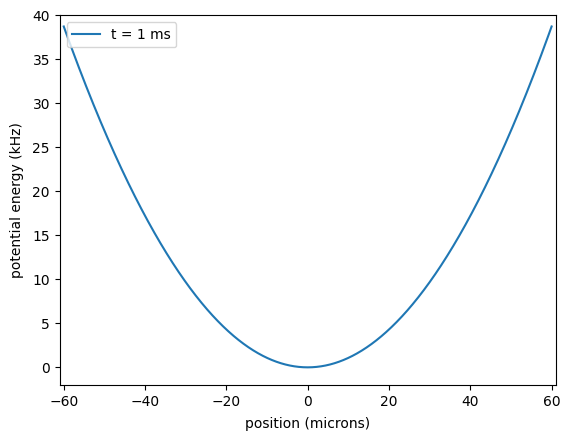

In [15]:
# Loop over in-trap times to populate list of matter objects
for time in it_times:

    # Append matter object to list
    batch_matters_it.append(
        qmf.create_quantum_matter(
            temperature=temp,
            lifetime=2 * time,
            landscape=landscape_slant,
            image="IN_TRAP",
        )
    )

# Plot what the potential looks like at time t=0
batch_matters_it[-1].show_potential(times=[1], ylimits=[-2, 40])

In [ ]:
batch_matter= qmf.submit_list_as_batch(
    matter_list=batch_matters_it, name="Dark Soliton batch 2", track=True  # global batch name
)

In [16]:
ds_jobs = qmf.search_jobs(name="Dark Soliton batch 2", limit=3, show_results=True)

Search returned 1 job(s):

╒══════════════════════╤════════════╤══════════╤══════════════════════════════════════╕
│ Name                 │ Job Type   │ Status   │ ID                                   │
╞══════════════════════╪════════════╪══════════╪══════════════════════════════════════╡
│ Dark Soliton batch 2 │ PAINT_1D   │ COMPLETE │ b0c38a1d-bf69-4eec-838a-4c40ca5e0f66 │
╘══════════════════════╧════════════╧══════════╧══════════════════════════════════════╛


In [17]:
ds_nob_jobs = qmf.search_jobs(name="Dark Soliton: no barrier", limit=3, show_results=True)

Search returned 1 job(s):

╒══════════════════════════╤════════════╤══════════╤══════════════════════════════════════╕
│ Name                     │ Job Type   │ Status   │ ID                                   │
╞══════════════════════════╪════════════╪══════════╪══════════════════════════════════════╡
│ Dark Soliton: no barrier │ BARRIER    │ COMPLETE │ 517fa48b-62cc-42d8-b270-9f73a8978d4d │
╘══════════════════════════╧════════════╧══════════╧══════════════════════════════════════╛


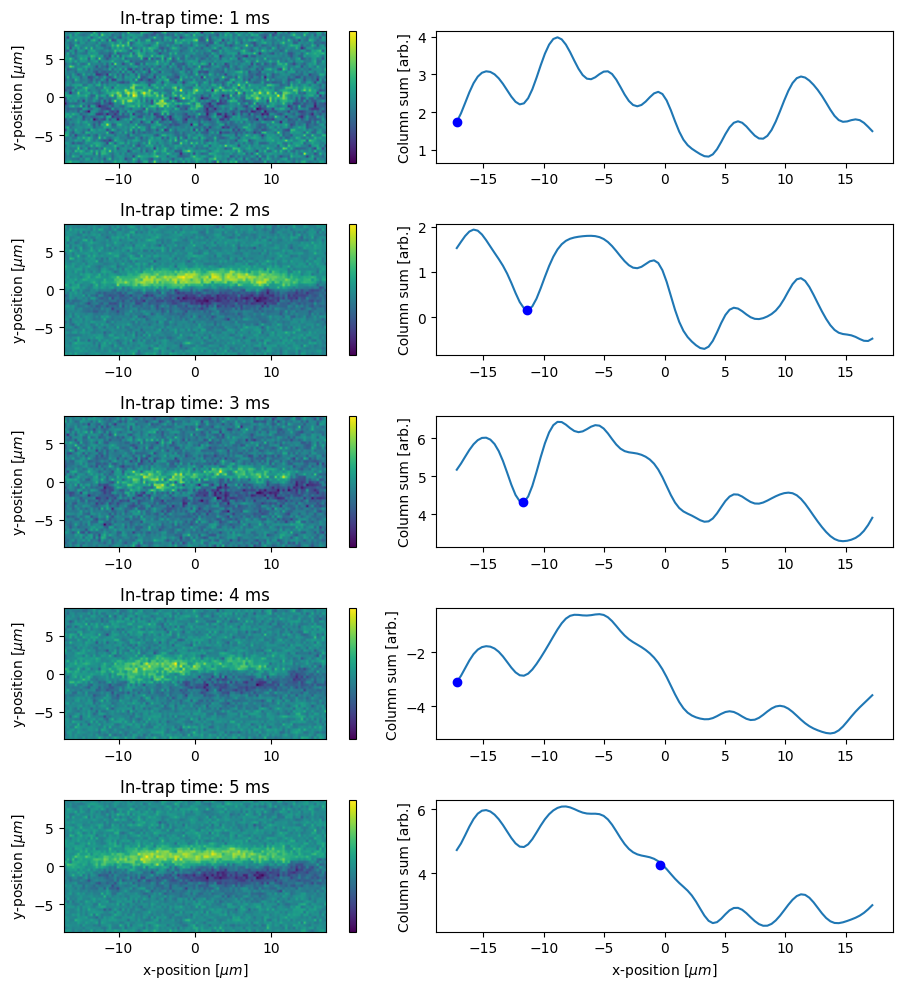

In [30]:
position = 0
min_positions = []  # To store the minimum density positions during data processing
window_x, window_y = (100, 50)  # Window widths (pixels) for plotting
filter_width = 3  # Width (pixels) for filtering/smoothing data
    
# Get baseline data from the job without a barrier
baseline_job = qmf.load_matter_from_job_id(job_id=ds_nob_jobs[0]["external_id"], run=1)
im_baseline = baseline_job.output.get_image_data()

# Set up subplot array for plotting
fig, axs = plt.subplots(len(it_times), 2, figsize=(10, 2 * len(it_times)))

# Loop over varying in-trap times
for i in range(len(batch_matters_it)):
    
    # Load data from the job
    job = qmf.load_matter_from_job_id(job_id=ds_jobs[0]["external_id"], run=i+1)
    #job = batch_matter.get_result(run=run + 1)

    # Extract data from output
    pix_cal = job.output.it_plot.pixcal
    im = job.output.get_image_data()
    rows, cols = im.shape

    # Subtract baseline image to more clearly see the density wave
    im = im - im_baseline

    # Create a column sum of the image to simplify data processing
    col_sum = np.sum(im, axis=0)
    col_sum = gaussian_filter(col_sum, filter_width)

    # Find the location of peak density to the left of the initial barrier
    idx_left = int(cols / 2 - window_x / 2)
    idx_right = int(cols / 2 + window_x / 2 )
    idx_center = int(cols / 2)
    indexMin = np.argmin(col_sum[idx_left:idx_center]) 
    min_positions.append(pix_cal * (indexMin - window_x / 2))

    # Plot the image of the density wave
    extent = (
        -pix_cal * window_x / 2,
        pix_cal * window_x / 2,
        -pix_cal * window_y / 2,
        pix_cal * window_y / 2,
    )
    im_fig = axs[i, 0].imshow(
        im[
            int(rows / 2 - window_y / 2) : int(rows / 2 + window_y / 2),
            int(cols / 2 - window_x / 2) : int(cols / 2 + window_x / 2),
        ],
        extent=extent,
    )
    axs[i, 0].set_ylabel(r"y-position [$\mu m$]")
    axs[i, 0].set_title(f"In-trap time: {it_times[i]:.0f} ms")
    cbar = plt.colorbar(im_fig, ax=axs[i, 0])
    cbar.set_ticks([])
    if i == len(it_times) - 1:
        axs[i, 0].set_xlabel(r"x-position [$\mu m$]")

    # Plot the column sum and location of peak density
    axs[i, 1].plot(
        pix_cal * np.linspace(-window_x / 2, window_x / 2, num=window_x),
        col_sum[int(cols / 2 - window_x / 2) : int(cols / 2 + window_x / 2)],
    )
    axs[i, 1].plot(
        min_positions[-1], col_sum[int(cols / 2 - window_x / 2 + indexMin)], "bo"
    )
    axs[i, 1].set_ylabel("Column sum [arb.]")
    if i == len(it_times) - 1:
        axs[i, 1].set_xlabel(r"x-position [$\mu m$]")

fig.tight_layout()

In [23]:
min_positions

[-2.2359999999999998, -11.18, -11.524, -11.524, -0.172]

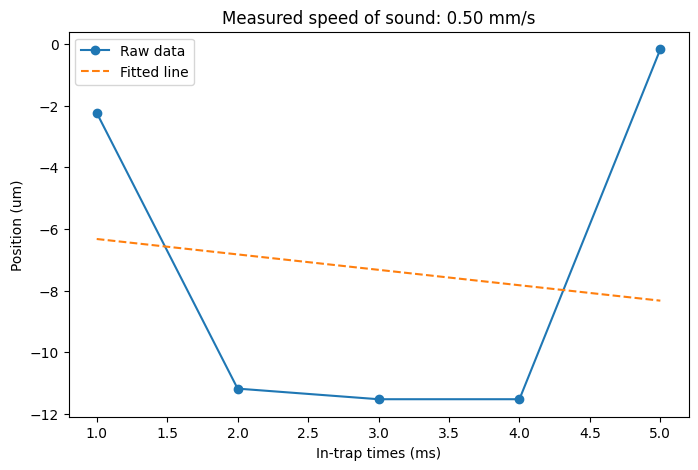

In [26]:
# Line function used for fitting
def line(x, a, b):
    return -a * x + b


# Calculate the speed of sound from the data by fitting peak density position over time to a line
initial_guess = np.array([2, min_positions[0]])  # Initial guess of fit parameters
bl = initial_guess - [1.5, 10]  # Lower bounds
bu = initial_guess + [1.5, 10]  # Upper bounds

popt, _ = opt.curve_fit(
    line, it_times, min_positions, p0=initial_guess, bounds=(bl, bu)
)

# Plot position of the peak density versus in-trap time
plt.figure(figsize=(8, 5))
plt.title(f"Measured speed of sound: {popt[0]:0.2f} mm/s")
plt.plot(it_times, np.array(min_positions), marker="o", label="Raw data")
plt.plot(it_times, line(it_times, *popt), "--", label="Fitted line")
plt.legend()
plt.xlabel("In-trap times (ms)")
plt.ylabel("Position (um)")

plt.show()